In [10]:
from requests import get
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
def get_response(url):
    response = get(url)
    # print(response.text)
    json = response.json()
    return pd.DataFrame(json[1:], columns=json[0])

In [32]:
url = f'https://api.census.gov/data/2021/pep/population?get=NAME,POP_2020&POP_2021&RANK_POP_2020&RANK_POP_2021&for=state:*'
df = get_response(url)

df['POP_2020'] = df['POP_2020'].astype(int)
df['POP_2021'] = df['POP_2021'].astype(int)

df['Change'] = df['POP_2021'] - df['POP_2020']
df['%Change'] = df['Change'] / df['POP_2020'] * 100

df = df[df['RANK_POP_2021'].notna()]
df = df[df['RANK_POP_2020'].notna()]

df['RANK_POP_2021'] = df['RANK_POP_2021'].astype(int)
df['RANK_POP_2020'] = df['RANK_POP_2020'].astype(int)

# df = df.drop("state", axis = 1)
df['POP_2021'] = df['POP_2021'].astype(int)
df['state'] = df['state'].astype(int)
# df["Change"] = df["Change"].abs()
# df["%Change"] = df["%Change"].abs()

df.sort_values(by=['NAME'])


,NAME,POP_2020,POP_2021,RANK_POP_2020,RANK_POP_2021,state,Change,%Change
48,Alabama,5024803,5039877,24,24,1,15074,0.299992
51,Alaska,732441,732673,48,48,2,232,0.031675
45,Arizona,7177986,7276316,14,14,4,98330,1.369883
12,Arkansas,3012232,3025891,33,33,5,13659,0.453451
19,California,39499738,39237836,1,1,6,-261902,-0.663047
28,Colorado,5784308,5812069,21,21,8,27761,0.479936
39,Connecticut,3600260,3605597,29,29,9,5337,0.148239
23,Delaware,991886,1003384,45,45,10,11498,1.159206
9,District of Columbia,690093,670050,49,49,11,-20043,-2.904391
40,Florida,21569932,21781128,3,3,12,211196,0.979122


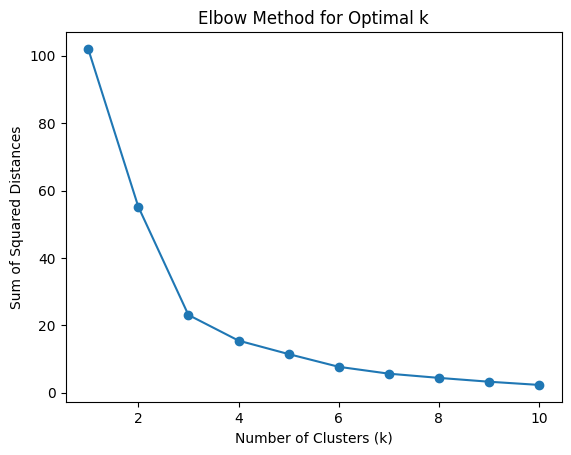

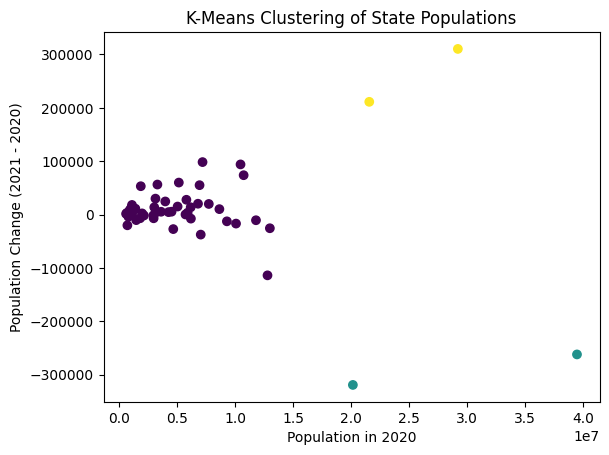

In [33]:
data = df


data['PopulationChange'] = data['POP_2021'] - data['POP_2020']

features = data[['POP_2020', 'PopulationChange']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

optimal_k = 3
final_model = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
final_model.fit(scaled_data)

data['Cluster'] = final_model.labels_

plt.scatter(data['POP_2020'], data['PopulationChange'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Population in 2020')
plt.ylabel('Population Change (2021 - 2020)')
plt.title('K-Means Clustering of State Populations')
plt.show()

In [34]:
X = data[['POP_2020']]
y = data['Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 14295.953535796678
Mean Squared Error: 387344476.4335171
R-squared: 0.12570539784517787


In [35]:
X = data.drop('RANK_POP_2020', axis = 1)
y = data['RANK_POP_2020']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(multi_class="multinomial")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC AUC Score: {roc_auc}')

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f'Cross-Validation ROC AUC Scores: {cv_scores}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()





ValueError: ignored